# Preliminaries

## Imports

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage import data, img_as_float
from skimage import exposure

from sklearn import cluster, metrics
import math
import time

from sklearn import manifold, decomposition

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

## Data overview

In [ ]:
# Mount their Google Drive account to their Colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('drive/MyDrive/Colab Notebooks/Data/cleaned_data.csv')

In [ ]:
df

,description,image,lvl_1_category,lvl_2_category,lvl_3_category,lvl_1_category_encoded
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Curtains & Accessories,Curtains,4
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,0
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,0
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Bed Linen,Bedsheets,4
4,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Bed Linen,Bedsheets,4
...,...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker...,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,Baby & Kids Gifts,Stickers,0
1046,Wallmantra Large Vinyl Sticker Sticker (Pack o...,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,Baby & Kids Gifts,Stickers,0
1047,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,Baby & Kids Gifts,Stickers,0
1048,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,Baby & Kids Gifts,Stickers,0


# SIFT approach

## Features extraction

The features extraction is the part where we use SIFT.

In [ ]:
img_paths = ['drive/MyDrive/Colab Notebooks/Data/Images/Unsorted_images/' + img for img in df['image']]

descriptors = []
features = []
thresholded_descriptors = []
for idx, path in enumerate(img_paths) :
    # Loading the image
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

    # Resize the image
    img = cv2.resize(img, (500, 500))

    # Converting image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Applying SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    kp, img_descriptors = sift.detectAndCompute(gray_img,None) # Detects keypoints and computes the descriptors

    # Adding the keypoints on the image using circles
    img_features = cv2.drawKeypoints(
        gray_img,
        kp,
        0,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Normalize the descriptors by their norm so that they don't vary with contrast changes
    #try :
    #    descriptors_norms = np.linalg.norm(img_descriptors, axis=1, keepdims=True) # Calculate descriptors' norms
    #    normalized_descriptors = descriptors / descriptors_norms
    #except :
    #    normalized_descriptors = 0

    # Threshold descriptors' values so that they don't vary with exposure changes
    #threshold = 0.2
    #thresholded_normalized_descriptors = np.minimum(normalized_descriptors, threshold)
    #thresholded_descriptors.append(thresholded_normalized_descriptors)

    descriptors.append(img_descriptors)
    features.append(img_features)

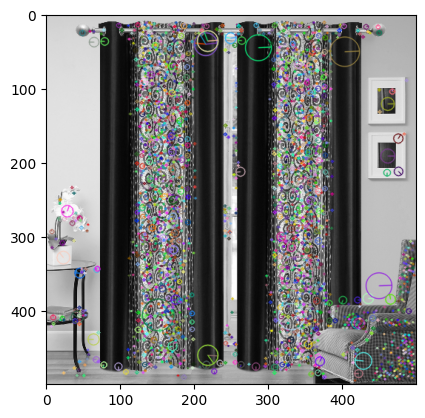

In [ ]:
plt.imshow(features[0])

error : no descriptors for the image of index  343


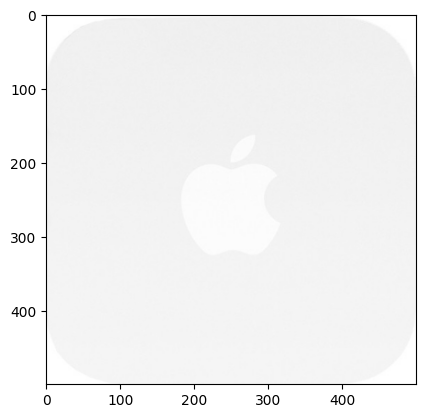

In [ ]:
# detect images without descriptors and create a subtitute of descriptor filled with zeros
for idx, des in enumerate(descriptors):
    try:
        if len(des) != 0:
            continue
    except:
        print('error : no descriptors for the image of index ', idx)
        plt.imshow(features[idx]) # show the image for which there are no descriptors
        descriptors[idx] = np.zeros((1,128)) # create a substitute filled with zeros

## Bag-of-features

### Creation of the visual words

In [ ]:
# concatenating all the descriptors
concatenated_des = np.concatenate(descriptors, axis=0)

concatenated_des.shape

(964008, 128)

In [ ]:
# fit a K-Means on concatenated descriptors
# the visual words are the centroïds of the features' classes distinguished by the K-Means
k = int(round(math.sqrt(len(concatenated_des)),0))
print('number of clusters : ', k)
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0, n_init='auto')
kmeans.fit(concatenated_des)

number of clusters :  982


MiniBatchKMeans(n_clusters=982, n_init='auto', random_state=0)

### Building the histograms

In [ ]:
def build_histogram(fitted_kmeans, img_descriptors):
    des_pred = fitted_kmeans.predict(img_descriptors)
    n_des = len(img_descriptors)
    hist, bin_edges = np.histogram(des_pred, bins=np.arange(fitted_kmeans.n_clusters+1))
    return hist/n_des # return normalized histogram values

histograms = []

for i in range(len(descriptors)):
    des = np.array(descriptors[i],dtype = np.float64)
    histograms.append(build_histogram(kmeans,des))

## Dimension reduction — PCA & T-SNE

In [ ]:
pca = decomposition.PCA(n_components=0.99)
pca_features= pca.fit_transform(histograms)
pca_features.shape

(1050, 562)

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(pca_features)

## Analysis

Adjusted Rand Index =  0.05


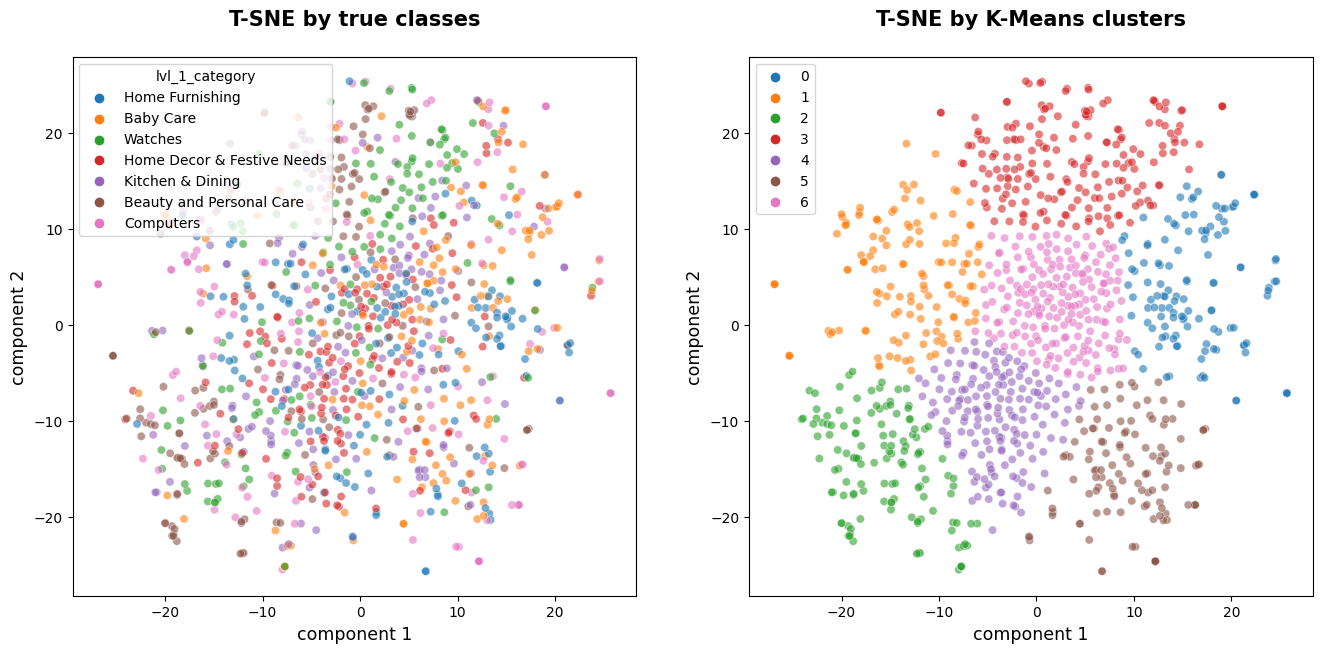

In [ ]:
kmeans = KMeans(n_clusters=7, n_init=10)
clusters = kmeans.fit_predict(X_tsne)

ARI = round(adjusted_rand_score(df['lvl_1_category'], clusters), 2)
print('Adjusted Rand Index = ', ARI)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16, 7))
ax1.set_title('T-SNE by true classes\n', fontsize=15, fontweight = 'bold')
ax1.set_xlabel('component 1', fontsize = 12.5)
ax1.set_ylabel('component 2', fontsize = 12.5)
ax2.set_title('T-SNE by K-Means clusters\n', fontsize=15, fontweight = 'bold')
ax2.set_xlabel('component 1', fontsize = 12.5)
ax2.set_ylabel('component 2', fontsize = 12.5)
sns.scatterplot(x=X_tsne[:,0],
                y=X_tsne[:,1],
                hue=df['lvl_1_category'],
                alpha=0.6,
                ax=ax1)
sns.scatterplot(x=X_tsne[:,0],
                y=X_tsne[:,1],
                hue=clusters,
                palette=sns.color_palette('tab10', n_colors=7),
                alpha=0.6,
                ax=ax2)
plt.show()

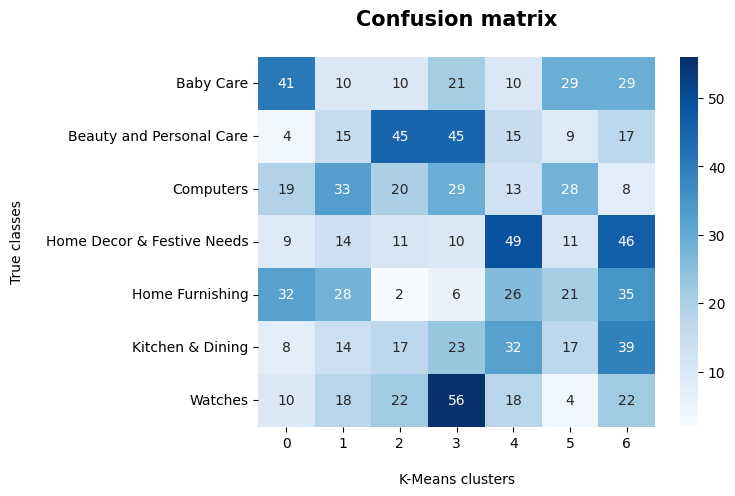

In [ ]:
cm = confusion_matrix(df['lvl_1_category_encoded'], clusters)

y_axis_labels =[]
for i in range(len(df['lvl_1_category'].unique())):
    idx = np.where(df['lvl_1_category_encoded'].unique()==i)[0][0]
    y_axis_labels.append(df['lvl_1_category'].unique()[idx])

plt.title('Confusion matrix\n', fontsize=15, fontweight = 'bold')
ax = sns.heatmap(cm, annot=True, fmt='g', yticklabels=y_axis_labels, cmap="Blues")
ax.set(xlabel='\nK-Means clusters', ylabel='True classes\n');

# CNN approach

## Creation of the pre-trained model

In [ ]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 9s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## Features extraction

In [ ]:
features = []
i=0
for path in img_paths :
    img = load_img(path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features.append(model.predict(img, verbose=0)[0]) # predict from pretrained model
    if i == 0 : print('progess tracking — number of images treated :')
    elif (i+1)%150 == 0 : print(i+1)
    i +=1

features = np.asarray(features)

progess tracking — number of images treated :
150
300
450
600


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


750
900
1050


## Dimension reduction — PCA & T-SNE

In [ ]:
print(features.shape)
pca = decomposition.PCA(n_components=0.99)
pca_features = pca.fit_transform(features)
print(pca_features.shape)

(1050, 4096)
(1050, 803)


In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(pca_features)

## Analysis

Adjusted Rand Index =  0.45


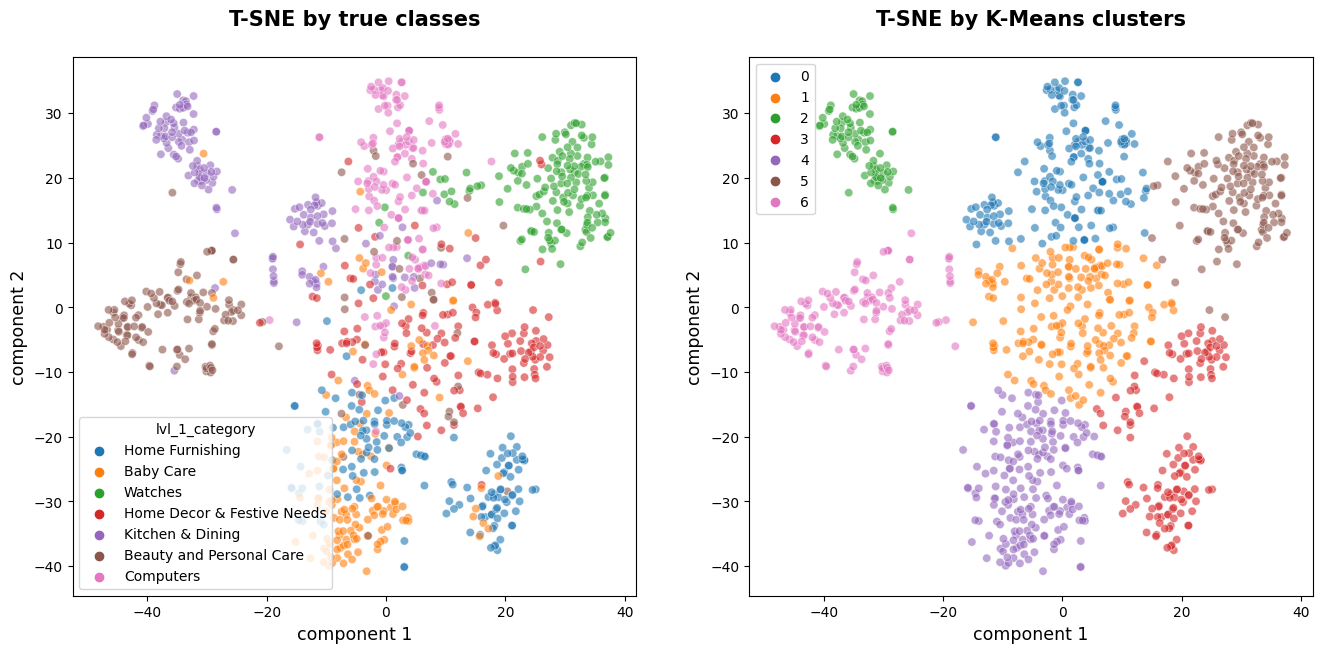

In [ ]:
kmeans = KMeans(n_clusters=7, n_init=10)
clusters = kmeans.fit_predict(X_tsne)

ARI = round(adjusted_rand_score(df['lvl_1_category'], clusters), 2)
print('Adjusted Rand Index = ', ARI)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16, 7))
ax1.set_title('T-SNE by true classes\n', fontsize=15, fontweight = 'bold')
ax1.set_xlabel('component 1', fontsize = 12.5)
ax1.set_ylabel('component 2', fontsize = 12.5)
ax2.set_title('T-SNE by K-Means clusters\n', fontsize=15, fontweight = 'bold')
ax2.set_xlabel('component 1', fontsize = 12.5)
ax2.set_ylabel('component 2', fontsize = 12.5)
sns.scatterplot(x=X_tsne[:,0],
                y=X_tsne[:,1],
                hue=df['lvl_1_category'],
                alpha=0.6,
                ax=ax1)
sns.scatterplot(x=X_tsne[:,0],
                y=X_tsne[:,1],
                hue=clusters,
                palette=sns.color_palette('tab10', n_colors=7),
                alpha=0.6,
                ax=ax2)
plt.show()

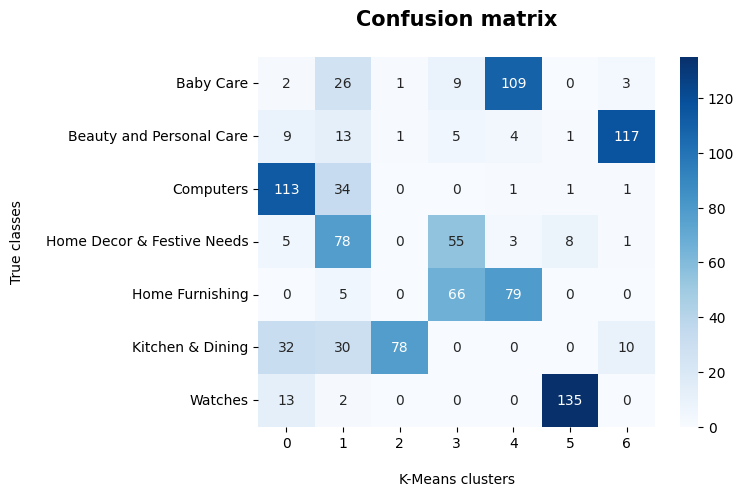

In [ ]:
cm = confusion_matrix(df['lvl_1_category_encoded'], clusters)

plt.title('Confusion matrix\n', fontsize=15, fontweight = 'bold')
ax = sns.heatmap(cm, annot=True, fmt='g', yticklabels=y_axis_labels, cmap="Blues")
ax.set(xlabel='\nK-Means clusters', ylabel='True classes\n');